# Research Project Midway Point (Healthcare & Technology)

### Adam Walmsley Rowan Murphy

### March 12th, 2025

##### AI Tool Use Declaration:
To write this proposal we did not use ChatGPT or any other form of generative AI


## Project Summary

In this project we are looking at how healthcare spending in Canada changes between provincial government parties and how effective their policies are at having a high quality, functioning healthcare system. Our ultimate goal is to diagnose the success of the various parties in Canada to get an unbiased view of how important the public healthcare system is to each part respectively.

## Research Questions

We have two members in our group and thus two distinct research questions, they are as follows:

1. With what level of importance do the different provincial government parties give to healthcare spending and is there one party that clearly cares more about public healthcare?

2. Which province has the most efficient healthcare spending?

We did not tweak our research questions much since the initial proposal. This is because we felt they were adequate and our TA had no problems whatsoever with them.

## Data Cleaning Steps

The following code and discussion will walk through our data cleaning process for all data sets.

We begin by importing the necessary libraries to enable our data cleaning process.

In [1]:
import pandas as pd
import altair as alt
import numpy as np
import openpyxl
import math
import matplotlib.pyplot as plt

#### Data Set 1: Provincial Governments

The first data set to tackle is provincial_governments_2000_2024.csv. We made this data set ourselves after compiling historical data for provincial governments in power since 2000. The data set contains data on BC, Alberta, Ontario and Quebec only. We kept the parties specific names in, and there exist the following distinct parties in the dataset:

- NDP
- BC Liberal Party
- Progressive Conservative Party
- United Conservative Party
- Liberal Party
- Parti Quebecois
- Coalition Avenir Quebec

After researching the similarities between similarily named parties we realized some should be combined into one specific naming convention. Specifically, we will combine: 
- BC Liberal Party and Liberal Party into just Liberal Party
- Progressive Conservative Party and United Conservative party into just Conservative Party

Parti Quebecois and Coalition Avenir Quebec are very distinct in their policies and these will be kept separate as they are. Also, we will remove the accents above the e's in the Quebec party names. To perform this cleaning we present the following code.

In [2]:
# Load in data
prov_df = pd.read_csv('Data/provincial_governments_2000_2024.csv')

# Select columns to change
columns_to_modify = [
    'BC Provincial Government',
    'Alberta Provincial Government',
    'Ontario Provincial Government',
    'Quebec Provincial Government'
]

# Identify specific replacements
replacements = {
    'BC Liberal Party': 'Liberal Party',
    'Progressive Conservative Party': 'Conservative Party',
    'United Conservative Party': 'Conservative Party',
    'Parti Québécois': 'Parti Quebecois',
    'Coalition Avenir Québec': 'Coalition Avenir Quebec'
}

# Apply changes
prov_df[columns_to_modify] = prov_df[columns_to_modify].replace(replacements)

Next, for compatibility we need to reorganize the layout of this dataset to be (Province, year, Government). We implement this with the following code.

In [3]:
# Pivot the dataframe to suggested format
df_long = pd.melt(prov_df, 
                  id_vars=['Year'], 
                  var_name='Province', 
                  value_name='Government')

# Clean up column names
df_long['Province'] = df_long['Province'].str.replace(' Provincial Government', '')
df_long['Province'] = df_long['Province'].str.replace('BC', 'BritishColumbia')


# Write to csv
df_long.to_csv('Data/Clean/provincial_governments_2000_2024.csv', index=False)

# Display cleaned and formatted data
df_long.head(3)

,Year,Province,Government
0,2000,BritishColumbia,NDP
1,2001,BritishColumbia,NDP
2,2002,BritishColumbia,Liberal Party


#### Data Set 2: Percent Health Expenditure

Next we look to clean the data set regarding provincial health expenditure per year percent increase across all provinces. This data set is particularly messy to begin with. We will perform the following operations to make the data suit our needs:

- Remove rows 1 to 56 since they contain data only on total expenditure whereas we want percent increase/decrease in expenditure which is found on rows 56 and below
- Remove rows past 105 since they contain other data we are not interested in
- Remove columns which concern provinces we are not interested in
- Remove rows from years outside of 2000 to 2024
- Correct data types for all data since initial spreadsheet has all strings
- Rename columns for better formatting

In [4]:
# Load in data
prov_spending_df = pd.read_csv('Data/nhex_prov_terr_data.csv', skiprows = 56, nrows = 49)

# Select columns we care about
columns_of_interest = [
    "Year", 
    "B.C.     ",
    "Alta.    ",
    "Ont.",
    "Que.  " 
]

# Drop columns be do not care about
prov_spending_df = prov_spending_df[columns_of_interest]

# Convert data to correct types
prov_spending_df["Year"] = prov_spending_df["Year"].astype(int)
other_columns = prov_spending_df.columns.difference(["Year"])
prov_spending_df[other_columns] = prov_spending_df[other_columns].astype(float)

# Drop years we are not concerned with
prov_spending_df = prov_spending_df[(prov_spending_df["Year"] >= 2000)]

prov_spending_df.reset_index(drop=True, inplace=True)

# Rename columns
prov_spending_df.rename(columns={
    "B.C.     ": "BritishColumbia",
    "Alta.    ": "Alberta",
    "Ont.": "Ontario",
    "Que.  ": "Quebec"
}, inplace=True)

Now, to ensure compatibility we reformat this dataset to the structure (province, year, percent_expenditure_change), we do this with the following code.

In [5]:
# Pivot
df_long_spending = pd.melt(prov_spending_df,
                  id_vars=['Year'],
                  var_name='Province',
                  value_name='Percent_expenditure_change')

# Write to csv
df_long_spending.to_csv('Data/Clean/nhex_prov_terr_data.csv', index=False)

# Display the cleaned and formatted data
df_long_spending.head(3)

,Year,Province,Percent_expenditure_change
0,2000,BritishColumbia,9.2
1,2001,BritishColumbia,10.4
2,2002,BritishColumbia,6.4


#### Data Set 3: Community Health Survey

For the second research question we will need quantitative data on health care spending, as percent change in expenditure will not suffice. To do this, we will need to read only rows 112 to 160 in the Excel file, and we will have to convert all values to numerical in order to be able to perform operations on our data. To make this work, we will need to specify that this dataset uses commas to distinguish large values, which would normally be flagged as non-numeric. Finally, this data has some missing values for Nunavut, so we will convert these missing values into np.nan values. Once we have read the data, we will need to correct the column names as the raw data includes several spaces in the column names which will be problematic when we later need to merge datasets.

In [6]:
nhex_percapita = pd.read_csv('https://raw.githubusercontent.com/RibbitsM/368-research-proj/refs/heads/main/Data/nhex_prov_terr_data.csv',
                        header=112, skiprows=lambda x: x > 160, dtype=np.float64, thousands=',', na_values='—')
nhex_percapita.columns = ['Year', 'N.L.', 'P.E.I.', 'N.S.', 'N.B.', 'Quebec', 'Ontario', 'Man.', 'Sask.', 'Alberta', 
                        'BritishColumbia', 'Y.T.', 'N.W.T', 'Nun.', 'Canada (Average)']
nhex_percapita.head()

,Year,N.L.,P.E.I.,N.S.,N.B.,Quebec,Ontario,Man.,Sask.,Alberta,BritishColumbia,Y.T.,N.W.T,Nun.,Canada (Average)
0,1975.0,357.92,352.59,322.88,300.87,399.86,377.83,367.52,329.31,384.21,371.34,281.70,355.89,NaN,376.32
1,1976.0,389.23,382.68,362.39,351.60,464.68,429.35,435.49,390.82,434.15,427.29,393.11,427.60,NaN,431.98
2,1977.0,412.98,419.50,398.29,390.49,508.18,462.03,479.36,434.85,451.21,464.19,444.82,525.96,NaN,467.93
3,1978.0,455.02,463.22,438.04,427.56,568.57,492.35,504.31,468.12,504.61,521.51,492.42,619.82,NaN,512.01
4,1979.0,521.43,508.78,486.34,478.80,632.25,527.10,549.26,529.79,600.00,583.99,538.34,610.04,NaN,565.94


Next, we will read in the data from the 2019-2020 community health survey. This is a very broad survey with almost 700 variables, but only a few are relevant to our analysis. Based on the documentation, we have selected the province of the respondant, as well as their responses to several questions related to the quality and efficiency of the health they have received or lack access to. All of these variables are originally categorical, and we will keep them in their numerical encodings so that we can aggregate them later on in the analysis.

In [7]:
keep_attributes = ['geogprv','PHC_060','PHC_035','PHC_005','PHC_020','UCN_005']
cchs_data = pd.read_stata("Data\cchs_201920_pumf.dta", columns=keep_attributes,convert_categoricals=False)
cchs_data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Data\\cchs_201920_pumf.dta'

You will notice that this means that the province of the respondant is also numerically encoded, which we will adjust to match the encoding from the health expenditure dataset for simplicity. Also, we will group and summarize our dataset to get the average responses to each question per province, to make comparisons across provinces easier.

In [ ]:
prov_dict = {47:"Sask.",59:'BritishColumbia',13:'N.B.',46:'Man.',35:'Ontario',12:'N.S.',24:'Quebec',10:'N.L.', 
            48: 'Alberta', 11: 'P.E.I.', 60: 'Terrs.'}
cchs_data['geogprv'] = cchs_data['geogprv'].replace(prov_dict)

cchs_data_avg = cchs_data.groupby('geogprv',axis=0).mean().round(3).reset_index()
cchs_data_avg

To match our survey data, we will need to select the expenditure data from only the years of the survey, which happen to be 2019 and 2020. Also, the community survey does not distinguish between data collected in Nunavut or the Yukon and Northwest Territories, and as such we will have to aggregate the per capita expenditure of all three territories into a single column.

In [ ]:
survey_year_expenditure = nhex_percapita[44:46]
survey_year_expenditure['Terrs.'] = ((survey_year_expenditure['Y.T.'] + survey_year_expenditure['N.W.T'] +
                                    survey_year_expenditure['Nun.'])/3)
survey_year_expenditure

To be able to merge our datasets we will need to drop the original territories columns, as well as the Year and Canada Average columns

In [ ]:
survey_year_expenditure = survey_year_expenditure.drop(['Year', 'Canada (Average)','Y.T.','N.W.T','Nun.'], axis=1)
survey_year_expenditure

Finally, we will pivot our dataframe and aggregate the values to get the average per capita expenditure for each province across 2019 and 2020 as a column, and the province name as another column. This is the proper formatting that will allow us to perform a natural join with our survey data

In [ ]:
nhex_pivot = survey_year_expenditure.melt(var_name='geogprv',value_name='avg_percap_spend'
                                        ).groupby('geogprv').mean().round(3).reset_index()
nhex_pivot

Using the merge function, we can finally join our two datasets together to get a dataframe that can be used for visualize our research question. Keep in mind we still have some NaN values, unfortunately not all survey questions were asked in all provinces.

In [12]:
combined_data = nhex_pivot.merge(cchs_data_avg, on='geogprv')
combined_data

## Exploratory Data Analysis

In this section we will take a closer look at the trends in our data to gain insight that we can use before further analysis. 

The first thing we will look at is the frequency of each party. To do this we will first plot a histogram of the parties and then a histogram of party by province.

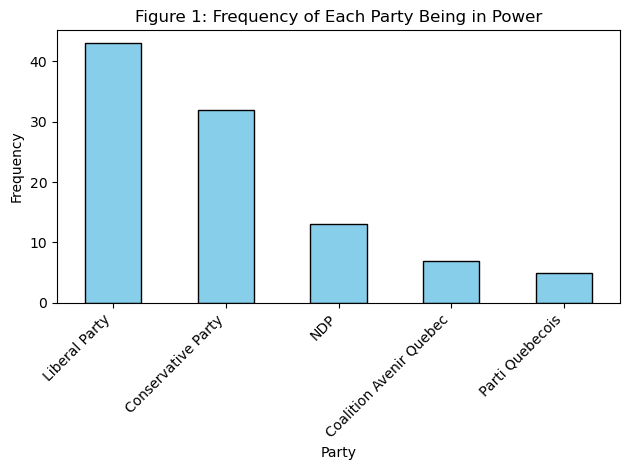

In [8]:
# Load in the clean data of provincial governments in power by year
prov_df = pd.read_csv('Data/Clean/provincial_governments_2000_2024.csv')

# Drop year column
parties_df = prov_df.drop(columns=['Year','Province'])

# Create single list for all occurences of parties
all_parties = parties_df.values.ravel()

# Count occurences of each party
party_counts = pd.Series(all_parties).value_counts()

# Plot frequency of each party being in power
party_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Figure 1: Frequency of Each Party Being in Power')
plt.xlabel('Party')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate labels for clarity if needed
plt.tight_layout()  # Ensures labels/titles fit nicely
plt.show()

From figure 1 above we can see that the Liberal Party is very well represented in our data whereas Coalition Avenir Quebec and Parti Quebecois are not. This is critical information to know since for our first research question we will be using hpyothesis testing and if there are not many samples for certain groups then our power will be very low. As a result of this we may end up exluding Quebec as a province in our analysis so we can focus on more mainstream parties in Canada.

For our next visualization we will look into the data on percent change in expenditure for public health. We will plot The percent change in expenditure for each province over the timeline of the datas set to see if there is much of a difference between provinces over the past 24 years.

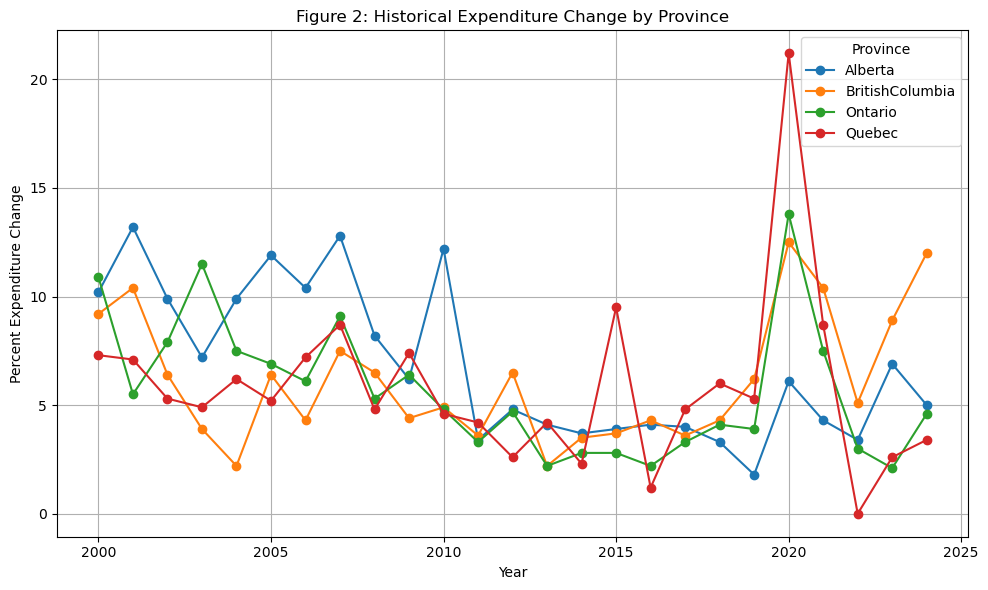

In [9]:
# Load in the cleaned data
expenditure_df = pd.read_csv('Data/Clean/nhex_prov_terr_data.csv')

# Create a figure
plt.figure(figsize=(10, 6))

# Plot a line for each province
for province, group in expenditure_df.groupby('Province'):
    plt.plot(group['Year'], group['Percent_expenditure_change'], marker='o', label=province)

# Customize the plot
plt.title('Figure 2: Historical Expenditure Change by Province')
plt.xlabel('Year')
plt.ylabel('Percent Expenditure Change')
plt.legend(title='Province')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

The visualization in figure 2 lets us see if each province generally maintains the same trends in healthcare spending. This will give us insight into whether government type really does affect percent increase in expenditure for public health and this graph does just that. We can see a general trend in spending, but there exist differences between provinces which is crucial. Further, it is interesting to note that we can clearly see the spike due to the Covid-19 pandemic. 

For the second research question, our dataset only has a few variables in it so we should be able to fit all of them into one comprehensive visualization, or at least a set of visualizations. We're going to make several scatterplots with a survey variable on the x axis and the per capita spending on the y axis with the points coloured by province, which should hopefully give an indication of any correlations or patterns in the data.

In [ ]:
PHC_060_chart = alt.Chart(combined_data).mark_circle().encode(
    alt.X('PHC_060').scale(domain=[1, 3.5]),
    alt.Y('avg_percap_spend').scale(domain=[4000, 13000]),
    alt.Color('geogprv'))

PHC_035_chart = alt.Chart(combined_data, title="Figure 3: Average Expenditure per Capita by Province and Survey Metric").mark_circle().encode(
    alt.X('PHC_035').scale(domain=[1, 4.5]),
    alt.Y('avg_percap_spend').scale(domain=[4000, 13000]),
    alt.Color('geogprv'))

PHC_005_chart = alt.Chart(combined_data).mark_circle().encode(
    alt.X('PHC_005').scale(domain=[1, 1.2]),
    alt.Y('avg_percap_spend').scale(domain=[4000, 13000]),
    alt.Color('geogprv'))

PHC_020_chart = alt.Chart(combined_data).mark_circle().encode(
    alt.X('PHC_020').scale(domain=[1, 1.5]),
    alt.Y('avg_percap_spend').scale(domain=[4000, 13000]),
    alt.Color('geogprv'))

UCN_005_chart = alt.Chart(combined_data).mark_circle().encode(
    alt.X('UCN_005').scale(domain=[1, 2.1]),
    alt.Y('avg_percap_spend').scale(domain=[4000, 13000]),
    alt.Color('geogprv'))

PHC_060_chart & PHC_020_chart | PHC_035_chart & UCN_005_chart | PHC_005_chart 

Here is the chart in case it doesn't appear on Github:

![visualization](visualization.png)

## Results fom our EDA Process

In figure 1 we saw the underrepresentation of 2 parties in Quebec. From this we will likely exclude Quebec as a province in parts of our analysis since the number of samples is likely too small to make meaningful conclusion with. This will change the way we handle our data since we will have to end up exluding Quebec during our analysis later on.

There's a couple important things to note with figure 3. First of all, it seems like some variables have much more variation between provinces compared to others. Specifically, PHC_020 (Access to regular health provider), PHC_060 (Coordination between health providers), and PHC_035 (Waiting time for minor health issues) seem to be particularly spread out. There are also two notable outliers, in Newfoundland and Labrador and particularly the Territories. Both of these regions have significantly higher spending per capita and while there isn't as clear of a trend in the survey variables, they tend to stick towards the right end of the graph, which indicates poorer health care as the most positive encoding for each variable is 1. Especially with access to regular health provider, this disparity is extremely notable. While this is like a product of geography and not a bias because of the smaller population, it would probably be worth it adding the total expenditure for each province as another variable.

In [ ]:
nhex_total = pd.read_csv('https://raw.githubusercontent.com/RibbitsM/368-research-proj/refs/heads/main/Data/nhex_prov_terr_data.csv',
                        header=4, skiprows=lambda x: x > 51, dtype=np.float64, thousands=',', na_values='—')
nhex_total.columns = ['Year', 'N.L.', 'P.E.I.', 'N.S.', 'N.B.', 'Quebec', 'Ontario', 'Man.', 'Sask.', 'Alberta', 
                        'BritishColumbia', 'Y.T.', 'N.W.T', 'Nun.', 'Canada (Average)']
total_year = nhex_total[44:46]
total_year['Terrs'] = ((total_year['Y.T.'] + total_year['N.W.T'] +
                                    total_year['Nun.'])/3)
total_year = total_year.drop(['Year', 'Canada (Average)','Y.T.','N.W.T','Nun.'], axis=1)
total_pivot = total_year.melt(var_name='geogprv',value_name='avg_total_spend'
                                        ).groupby('geogprv').mean().round(3).reset_index()
combined_total = combined_data.merge(total_pivot, on='geogprv')
combined_total['Year'] = ['2019','2019','2019','2019','2019','2019','2019','2019','2019','2019']
combined_total

The year column was added so that it can be referenced as a foreign key, but it's mostly redundant as all the survey data is from an unknown time between 2019 and 2020. With all this done, we should finally be ready to move on and save this data to a csv file

In [ ]:
combined_total.to_csv("Data/Clean/nhexandcchs.csv")

Next, we will need to generate the SQL script to insert this data into a database. This function takes a path to a cleaned csv file, the name of the sql file to be created, and the name of an SQL table and generates a text file containing insert statements to insert all data within the provided csv file into an SQL table. This also works with nan values which will automatically be converted to sql Null values.

In [8]:
def make_sql(input_file, output_file, table_name):
    data = pd.read_csv(input_file)
    with open(output_file, "w") as f:
        f.write("")
    for index, row in data.iterrows():
        with open(output_file, "a") as f:
            f.write("\ninsert into " + table_name + " \nvalues(")
            for item in range(data.shape[1]):
                if item == data.shape[1] - 1:
                    if str(row[item]) == 'nan':
                        f.write("NULL"+', ')
                    else:
                        f.write("'"+str(row[item])+"'"+');\n')
                else:
                    if str(row[item]) == 'nan':
                        f.write("NULL"+', ')
                    else:
                        f.write("'"+str(row[item])+"'"+', ')

In [10]:
#make_sql("Data/Clean/nhexandcchs.csv", "balls.sql", "survey_expenditure")
make_sql("Data/Clean/provincial_governments_2000_2024.csv","SQL/provincial_governments_2000_2024.sql", "provincial_governments")
make_sql("Data/Clean/nhex_prov_terr_data.csv","SQL/nhex_prov_terr_data.sql", "percent_expenditure_change")

/var/folders/ms/qqqflpss15dgyth1sr176lyw0000gn/T/ipykernel_61427/3319613684.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if str(row[item]) == 'nan':
/var/folders/ms/qqqflpss15dgyth1sr176lyw0000gn/T/ipykernel_61427/3319613684.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f.write("'"+str(row[item])+"'"+', ')
/var/folders/ms/qqqflpss15dgyth1sr176lyw0000gn/T/ipykernel_61427/3319613684.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

## Schema for our Database

The schema of our database is as follows:

- provincial_governments(Province, Year, Party), Primary Key(Province, Year), Foreign Key(Province) referencing survey_expenditure
- percent_expenditure_change(Province, Year, percent_expenditure_change), Primary Key(Province, Year), Foreign Key(Province, Year) referencing provincial_governments, Province referencing survey_expenditure
- survey_expenditure(Province, PerCapSpend, Coordination, WaitingTime, CareAccess, ProviderAccess, UnmetNeeds, TotalSpend, Year), Primary Key (Province), Foreign Key (Year) referencing provincial_governments. PerCapSpend, Coordination, WaitingTime, CareAccess, ProviderAccess, TotalSpend, and Year are all not null.

This schema may at first seem redundant since we could combine all our data into one table but there are a few reasons why this implementation is useful. Firstly, each table is concerned with conceptually distinct data. If we were to combine them all then it would be not obvious what the specific use of the table is. Also, this layout offers increases flexibility. Since each table concerns a distinct data set to begin with, the amount of updates and the frequency of them is likely to be different in the future and this schema allows for that.